Here we develop the codes needed to evaluate chi-squareds between measured x-corr and models

First, we need to figure out rebinning between the models provided by Andreu, and the irregular bins we're using for the x-corr measurement 

In [1]:
import numpy as np
from astropy.io import ascii

def rebin_model_to_xcorr(delta_z, SigModel, PiModel, SigEdges, PiEdges):
    """Returns an array of subscripts to map model grid to observed grid, as a function of delta_z.
    
    Inputs: 
        delta_z   - Desired offset along LOS (pi) direction, in same units as Pi and Sigma (i.e. Mpc/h)
        SigModel, PiModel - sigma and pi positions of the models grid, as 1D vectors. This should 
                            the full vector of all pixels, not just unique val;ues
        SigEdges, PiEdges - sigma and pi bin edges of the output grid. Provide unique values 
        
    
    For each bin in the observed cross-correlation grid. return a list of model grid 1D subscripts"""
    
    nbins_out = (len(SigEdges)-1) * (len(PiEdges)-1)
    
    rebinned_indices = [None] * nbins_out
    
    SigEdges1 = SigEdges[:-1]
    SigEdges2 = SigEdges[1:]
    PiEdges1  = PiEdges[:-1]
    PiEdges2  = PiEdges[1:]
    
    ctr = 0
    for p1, p2 in zip(PiEdges1,PiEdges2):
        for s1, s2 in zip(SigEdges1, SigEdges2):
            grabpix =  np.where( (SigModel >= s1) & (SigModel < s2) & 
                                (PiModel+delta_z >= p1) & (PiModel+delta_z < p2) )
            rebinned_indices[ctr] = grabpix
            ctr += 1

    return rebinned_indices

<IPython.core.display.Javascript object>


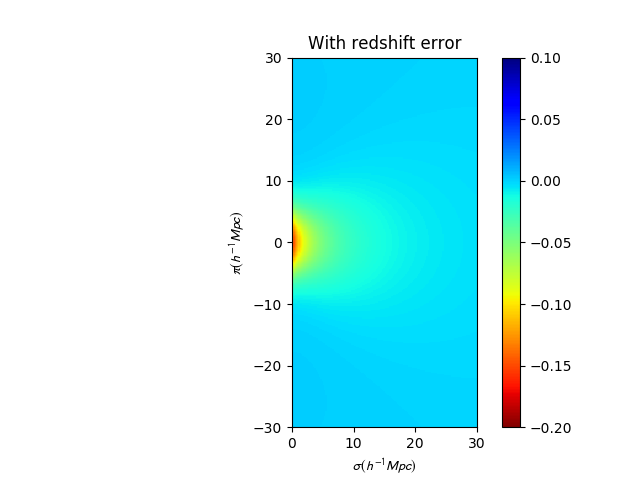

In [2]:
# Test reflecting the axes
modfil = 'model_grid_v0/linear_cross_b1.4_s3.31155.txt'
mod_raw = ascii.read(modfil, format='no_header', names=['rt', 'rp', 'xi_lin', 'xi_conv'])

rt = mod_raw['rt']
rp = mod_raw['rp']
xi_lin = mod_raw['xi_lin']
xi_conv = mod_raw['xi_conv']

# reflect along pi axis
rp2 = rp * -1.

# Create an structured array
dtype =[('rp', 'f8'), ('rt', 'f8'), ('xi_conv', 'f8'), ('xi_lin', 'f8')]

mod_raw = np.zeros(len(xi_conv)*2, dtype=dtype)

mod_raw['rp'] = np.append(rp, rp2)
mod_raw['rt'] = np.append(rt,rt)
mod_raw['xi_conv'] = np.append(xi_conv, xi_conv)
mod_raw['xi_lin'] = np.append(xi_lin, xi_lin)

mod_raw = np.sort(mod_raw, order=['rt', 'rp'])

sigma = np.sort(np.unique(mod_raw['rt']))
pi = np.sort(np.unique(mod_raw['rp']))

xi_conv2d = np.reshape(mod_raw['xi_conv'], (len(sigma),len(pi)))

# Plot as sanity check
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib notebook

fig, ax, = plt.subplots()

# WARNING: ignoring the fact that these aren't the bin edges but centers!
X,Y = np.meshgrid(sigma, pi)
#print(len(sigma), len(pi), np.shape(xi_conv1))
#print(np.shape(np.transpose(xi_lin1)))
pcm = ax.pcolormesh(X,Y,np.transpose(xi_conv2d), cmap='jet_r', vmin=-0.2,vmax=0.1)
ax.set_aspect('equal')
ax.set_xlim(0, 30.)
ax.set_ylim(-30, 30.)
ax.set_title("With redshift error")
ax.set_xlabel(r"$\sigma (h^{-1} Mpc)$")
ax.set_ylabel(r"$\pi (h^{-1} Mpc)$")


fig.colorbar(pcm)

plt.show()
            

Test rebinning code

In [3]:

#from astropy.cosmology import FlatLambdaCDM

PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
#PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
#SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

delta_z = 0.

rebinned_ind = rebin_model_to_xcorr(delta_z, mod_raw['rt'], mod_raw['rp'], SigEdges, PiEdges)

In [4]:
SigEdgesVec, PiEdgesVec = np.meshgrid(SigEdges, PiEdges)

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

SigEdgesPlot = SigEdgesVec/(np.ones(np.shape(SigEdgesVec))*[cosmo.h])
PiEdgesPlot = PiEdgesVec / (np.ones(np.shape(PiEdgesVec))*[cosmo.h])

SigEdgesFlat = np.ravel(SigEdgesVec)
PiEdgesFlat = np.ravel(PiEdgesVec)

print(len(SigEdges), len(PiEdges))
print(np.array_equal(SigEdgesVec, np.reshape(SigEdgesFlat, [24,10])))


10 24
True


In [5]:
nbins_out = (len(PiEdges)-1) * (len(SigEdges)-1)
XCorr_model_flat = np.empty(nbins_out)

xi_conv_in = mod_raw['xi_conv']

for i in range(nbins_out):
    ind_tmp = rebinned_ind[i][0]
    #print(len(ind_tmp))
    XCorr_model_flat[i] = np.mean(xi_conv_in[ind_tmp])
    


Plot the rebinned model in comparison with observed x-corr.

<IPython.core.display.Javascript object>


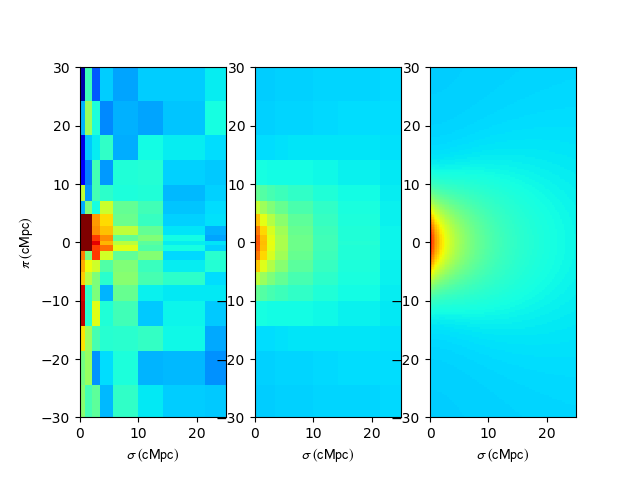

In [6]:

XCorr_model = np.reshape(XCorr_model_flat, [23,9])

XCorr_md=np.load("xcorr_mosdef_v3.npy")
XCorrPlot_md = np.transpose(XCorr_md)

fig, (ax1, ax2,ax3) = plt.subplots(1,3)
                            
SigMax = 25.
PiMin = -30.
PiMax = 30.

ax1.pcolormesh(SigEdgesPlot, PiEdgesPlot, XCorrPlot_md,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax1.set_aspect('equal')
ax1.set_xlim(0., SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

ax2.pcolormesh(SigEdgesPlot, PiEdgesPlot, XCorr_model,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax2.set_aspect('equal')
ax2.set_xlim(0., SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
#ax2.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

ax3.pcolormesh(X/(np.ones(np.shape(X))*[cosmo.h]),
               Y/(np.ones(np.shape(Y))*[cosmo.h]),np.transpose(xi_conv2d),
               cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax3.set_aspect('equal')
ax3.set_xlim(0., SigMax)
ax3.set_ylim(PiMin, PiMax)
ax3.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
#ax3.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

plt.show()

This is the wrapper to return the 2D model cross-correlation, given the filename and bin edges

In [7]:
def xcorr_model_binned(XCorrModelFil, SigEdges, PiEdges, delta_z = 0., LinearModel=False):
    """Given filename of forest cross-correlation model as provided by model, 
    return 2D x-correlation array that could be directly compared with the CLAMATO XCorr arrays 
    and covariances as read in from the numpy files
    
    This is useful for comparing a single model 
    
    Here, we assume everything is in Mpc/h (i.e. the distance units in Andreu Font's models)
    
    Inputs: 
        XCOrrModelFil  - Model file name
        SigEdges       - 1D vector of output transverse bin edges (unique)
        PiEdges        - 1D vector of output LOS bin edges (unique)
        delta_z        - LOS offset, in Mpc/h
    
    For the 2017 CLAMATO X-Corr analysis, the distances in the model files are all Mpc/h 
    so the bin parameters input to this function should be as well.
    
    Returns by default the model convolved with Gaussian redshift space distortions. 
    'Linear' can be set to True to return the underlying linear model.
    """
    
    nbins_Pi = len(PiEdges)-1
    nbins_Sig = len(SigEdges)-1
    nbins_out = ( nbins_Pi * nbins_Sig)
    
    mod_raw = ascii.read(XCorrModelFil, format='no_header', 
                         names=['rt', 'rp', 'xi_lin', 'xi_conv'])

    rt = mod_raw['rt']
    rp = mod_raw['rp']
    xi_lin = mod_raw['xi_lin']
    xi_conv = mod_raw['xi_conv']

    # reflect along pi axis
    rp2 = rp * -1.

    # Create an structured array
    dtype =[('rp', 'f8'), ('rt', 'f8'), ('xi_conv', 'f8'), ('xi_lin', 'f8')]

    mod_raw = np.zeros(len(xi_conv)*2, dtype=dtype)

    mod_raw['rp'] = np.append(rp, rp2)
    mod_raw['rt'] = np.append(rt,rt)
    mod_raw['xi_conv'] = np.append(xi_conv, xi_conv)
    mod_raw['xi_lin'] = np.append(xi_lin, xi_lin)
    
    mod_raw = np.sort(mod_raw, order=['rt', 'rp'])
    

    rebinned_ind = rebin_model_to_xcorr(delta_z, mod_raw['rt'], mod_raw['rp'], 
                                            SigEdges, PiEdges)
    
    XCorr_model_flat = np.empty(nbins_out)
    
    if LinearModel:
        xi_flat = mod_raw['xi_lin'] 
    else:
        xi_flat = mod_raw['xi_conv']

    for i in range(nbins_out):
        ind_tmp = rebinned_ind[i][0]
        XCorr_model_flat[i] = np.mean(xi_flat[ind_tmp])
        
    XCorr_model = np.reshape(XCorr_model_flat, [nbins_Pi,nbins_Sig])
    return np.transpose(XCorr_model)


Compute log-likelihood between model and data, and plot corresponding cross-correlations

Chi-squared =  110.183736265 for  206  dof


<IPython.core.display.Javascript object>


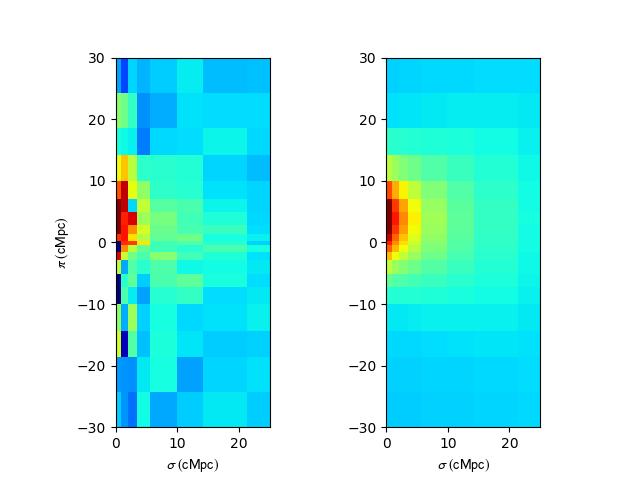

In [8]:
modfil = 'model_grid_v0/linear_cross_b2.2_s3.31155.txt'
PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
#PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
#SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

delta_z = 2.8

XCorrModel = xcorr_model_binned(modfil, SigEdges, PiEdges, delta_z=delta_z)

XCorr=np.load("xcorr_zDeep_v3.npy")
XCorrPlot = np.transpose(XCorr)
Cov = np.load("covar_zDeep_v3_n6400.npy")
InvCov = np.linalg.pinv(Cov)

DeltaVec = XCorr.reshape(XCorr.size) - XCorrModel.reshape(XCorrModel.size)

minusLogL =  np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("Chi-squared = ",  np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)), 'for ', nbins_out-1, ' dof')

fig, (ax1, ax2) = plt.subplots(1,2)
                            
SigMax = 25.
PiMin = -30.
PiMax = 30.

ax1.pcolormesh(SigEdgesPlot, PiEdgesPlot, XCorrPlot,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax1.set_aspect('equal')
ax1.set_xlim(0., SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

ax2.pcolormesh(SigEdgesPlot, PiEdgesPlot, np.transpose(XCorrModel)
               ,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax2.set_aspect('equal')
ax2.set_xlim(0., SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')

plt.show()

Test xcorrmodel module and class, which implements the above code. Crucially, we want to be able to separately calculate the rebin indices and rebin the model.

Chi-squared =  112.734557571 for  206  dof


<IPython.core.display.Javascript object>


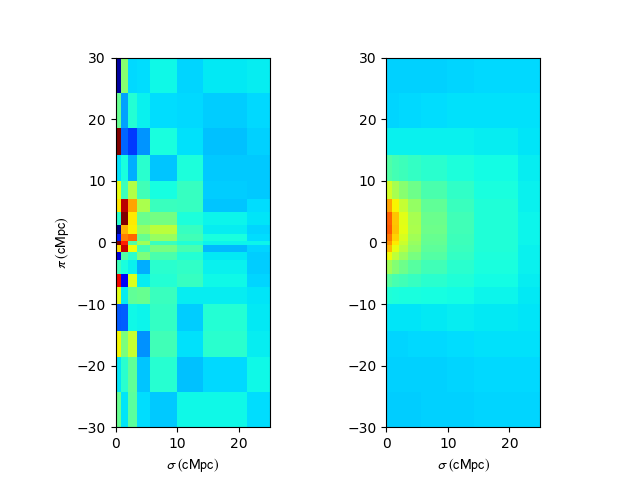

In [18]:
import xcorrmodel as xmodel

modfil = 'model_grid_v0/linear_cross_b1.4_s3.31155.txt'

mod1 = xmodel.XCorrModel(modfil)

PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
#PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
#SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

delta_z = 2.
indices = rebin_model_to_xcorr(delta_z, mod1.rt, mod1.rp, SigEdges, PiEdges)

XCorrModel = mod1.rebin2d(indices, SigEdges, PiEdges)

XCorr=np.load("xcorr_VUDS_v3.npy")
XCorrPlot = np.transpose(XCorr)
Cov = np.load("covar_VUDS_v3_n6400.npy")
InvCov = np.linalg.pinv(Cov)

DeltaVec = XCorr.reshape(XCorr.size) - XCorrModel.reshape(XCorrModel.size)

minusLogL =  np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("Chi-squared = ",  np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)), 'for ', nbins_out-1, ' dof')

fig, (ax1, ax2) = plt.subplots(1,2)
                            
SigMax = 25.
PiMin = -30.
PiMax = 30.

ax1.pcolormesh(SigEdgesPlot, PiEdgesPlot, XCorrPlot,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax1.set_aspect('equal')
ax1.set_xlim(0., SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

ax2.pcolormesh(SigEdgesPlot, PiEdgesPlot, np.transpose(XCorrModel)
               ,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax2.set_aspect('equal')
ax2.set_xlim(0., SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')

plt.show()